In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2],
    c2 = [0.5, 2],
    w = [0.5, 1.2],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = None,
    mask = None))

see one see two 2 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 5
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c1 = np.max([model.optimizer.C1[1] - ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[0]])
    model.optimizer.c2 = np.min([model.optimizer.C2[0] + ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])

Checkpoint 100, Accuracy: 0.8333333333333334, Loss: 0.6841268892641421
Checkpoint 200, Accuracy: 0.8271604938271605, Loss: 0.6836159317581741
Checkpoint 300, Accuracy: 0.8395061728395061, Loss: 0.6753479992901837
Checkpoint 400, Accuracy: 0.8271604938271605, Loss: 0.6754882247359665
Checkpoint 500, Accuracy: 0.8333333333333334, Loss: 0.670684673168041


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [[0.38016182]
 [0.37104288]
 [0.24879533]]
[0. 0. 1.] <-> [[0.24686816]
 [0.4415041 ]
 [0.31162775]]
[1. 0. 0.] <-> [[0.62954426]
 [0.22673528]
 [0.14372043]]
[1. 0. 0.] <-> [[0.9428312 ]
 [0.02958709]
 [0.0275817 ]]
[1. 0. 0.] <-> [[0.92699707]
 [0.03551552]
 [0.03748737]]
[1. 0. 0.] <-> [[0.44071043]
 [0.33943525]
 [0.21985434]]
[0. 1. 0.] <-> [[0.41794857]
 [0.3512524 ]
 [0.23079897]]
[1. 0. 0.] <-> [[0.94546956]
 [0.02735146]
 [0.02717892]]
[1. 0. 0.] <-> [[0.57915443]
 [0.2611707 ]
 [0.15967488]]
[1. 0. 0.] <-> [[0.9401217 ]
 [0.02858509]
 [0.03129325]]
[1. 0. 0.] <-> [[0.9440828 ]
 [0.0267407 ]
 [0.02917651]]
[0. 0. 1.] <-> [[0.94468117]
 [0.02809747]
 [0.02722136]]
[1. 0. 0.] <-> [[0.60546345]
 [0.24329491]
 [0.15124159]]
[0. 1. 0.] <-> [[0.6044244 ]
 [0.2440069 ]
 [0.15156862]]
[1. 0. 0.] <-> [[0.54945886]
 [0.28057274]
 [0.16996844]]
[1. 0. 0.] <-> [[0.4694632 ]
 [0.32462975]
 [0.20590703]]
[1. 0. 0.] <-> [[0.6914654 ]
 [0.18423462]
 [0.12429994]]
[1. 0. 0.] <->

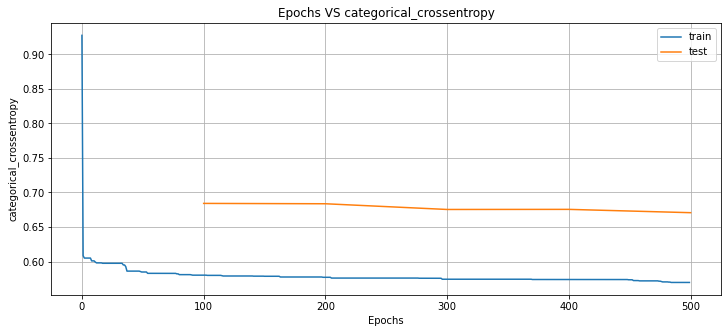

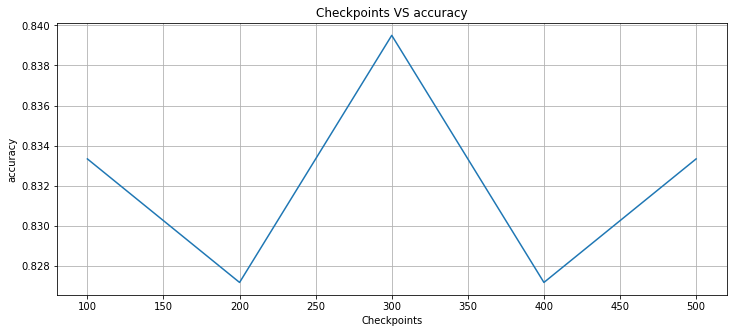

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.8333333333333334, 'mean_square_error': 2.926230113228317, 'categorical_crossentropy': 0.6841268892641421, 'essential_metrics': {0: {'tp_hit': 72, 'fp_hit': 15, 'tn_hit': 17, 'fn_hit': 4}, 1: {'tp_hit': 2, 'fp_hit': 7, 'tn_hit': 84, 'fn_hit': 15}, 2: {'tp_hit': 7, 'fp_hit': 5, 'tn_hit': 88, 'fn_hit': 8}}, 'checkpoint': 100} 


{'accuracy': 0.8271604938271605, 'mean_square_error': 2.941835255567875, 'categorical_crossentropy': 0.6836159317581741, 'essential_metrics': {0: {'tp_hit': 70, 'fp_hit': 15, 'tn_hit': 17, 'fn_hit': 6}, 1: {'tp_hit': 5, 'fp_hit': 11, 'tn_hit': 80, 'fn_hit': 12}, 2: {'tp_hit': 5, 'fp_hit': 2, 'tn_hit': 91, 'fn_hit': 10}}, 'checkpoint': 200} 


{'accuracy': 0.8395061728395061, 'mean_square_error': 2.973240359731033, 'categorical_crossentropy': 0.6753479992901837, 'essential_metrics': {0: {'tp_hit': 72, 'fp_hit': 15, 'tn_hit': 17, 'fn_hit': 4}, 1: {'tp_hit': 5, 'fp_hit': 9, 'tn_hit': 82, 'fn_hit': 12}, 2: {'tp_hit': 5, 'fp_hit': 2, 'tn_hit': 91, 'fn_hi

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[[ 0.49936017]
 [ 0.94731915]
 [-0.9706024 ]
 [ 1.2258685 ]
 [-1.0090878 ]]
 bias: [1.5407686]

Neuron 1: weights:
[[ 0.8844732 ]
 [ 0.7978086 ]
 [ 1.3939203 ]
 [-2.7675085 ]
 [ 0.13200985]]
 bias: [-1.7190051]

Neuron 2: weights:
[[-0.12598275]
 [ 1.949709  ]
 [-2.5563922 ]
 [ 1.8793471 ]
 [ 0.21967515]]
 bias: [-2.9716008]

Neuron 3: weights:
[[ 2.3354094]
 [ 1.9575268]
 [-0.8182186]
 [ 0.9477386]
 [ 3.       ]]
 bias: [1.2358605]

$
Layer 2
Neuron 0: weights:
[[ 1.4012661]
 [-0.7992516]
 [-2.9134471]
 [-1.8116933]]
 bias: [1.8974118]

Neuron 1: weights:
[[ 0.49443123]
 [-0.83589685]
 [ 1.8049555 ]
 [ 1.0595727 ]]
 bias: [-1.1150706]

Neuron 2: weights:
[[0.4446713 ]
 [3.        ]
 [0.996015  ]
 [0.27139717]]
 bias: [-1.4032447]

$

